In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def f(x):
    y = 3*x**2 - 4*x +5 
    return y

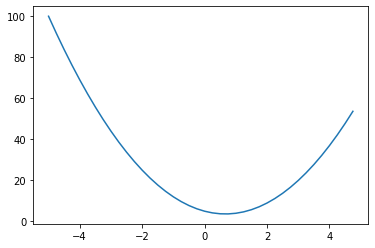

In [4]:
xs = np.arange(-5.0, 5.0, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
h = 0.000001
x = -3
(f(x+h) - f(x))/h

-21.999997002808414

In [23]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self._prev = set(_children)  # to save the information about the value's children (who create him, maybe parents is a better name)
        self._op = _op  # the operation to create this value, like '+' or '*'
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, _children=(self, other), _op='+')
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, _children=(self, other), _op='*')
        return out

In [19]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
a + b   # a.__add__(b) internally

Value(data=-1.0)

In [8]:
a*b  # a.__mul__(b) internally

Value(data=-6.0)

In [9]:
a*b + c   #(a.__mul__(b)).__add__(c)

Value(data=4.0)

In [10]:
d = a*b+c

In [11]:
d

Value(data=4.0)

In [12]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [13]:
d._op

'+'

In [20]:
from graphviz import Digraph

def trace(root):
    # build a set of nodes and edges of a computation grpah
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR= left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any node in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label="{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this node is created by some operations, create an op for it
            dot.node(name=uid+n._op, label=n._op)
            # connect this node to it
            dot.edge(uid+n._op, uid)
        
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2))+n2._op)
    
    return dot


In [28]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self._prev = set(_children)  # to save the information about the value's children (who create him, maybe parents is a better name)
        self._op = _op  # the operation to create this value, like '+' or '*'
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, _children=(self, other), _op='+')
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, _children=(self, other), _op='*')
        return out
    
    def tanh(self):
        x = self.data
        tanh = (math.exp(2*x) - 1)/(math.exp(2*x) + 1 )
        return Value(tanh, (self, ), 'tanh')

In [24]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label = 'e'   # a.__add__(b) internally
d = e + c; d.label='d'
f = Value(-2.0, label='f')
L = f*d; L.label='L'



In [26]:
# here are the gradient that L with respect to all the values
L.grad = 0
f.grad = d.data
d.grad = f.data
e.grad = d.grad * 1  # d.grad * dd/de 
c.grad = d.grad * 1
a.grad = e.grad * b.data
b.grad = e.grad * a.data

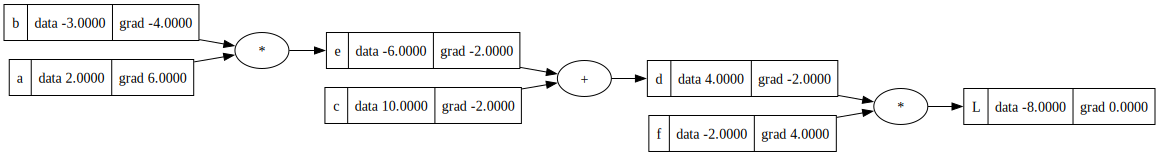

In [27]:
draw_dot(L)

In [80]:
# a simple example of a neuron
# input data
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weight 
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1x2w2'
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label='o'


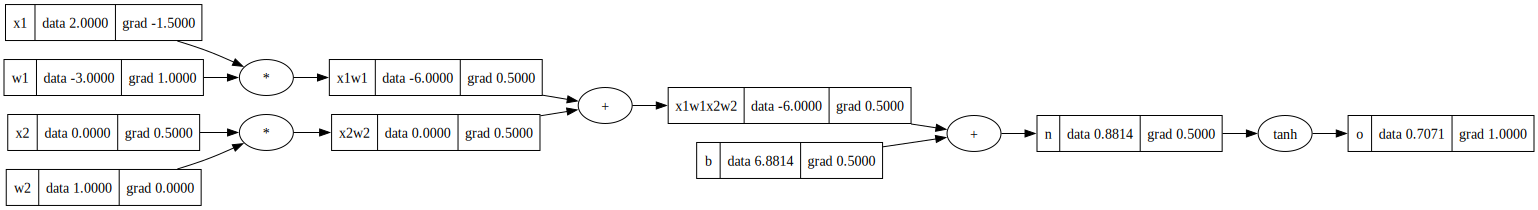

In [82]:

draw_dot(o)

In [81]:
# !!! the derivative equal to Global Derivative * Local Derivative

o.grad = 1.0
n.grad = 1 - o.data**2
x1w1x2w2.grad = n.grad * 1
b.grad = n.grad * 1
x1w1.grad = x1w1x2w2.grad * 1
x2w2.grad = x1w1x2w2.grad * 1
w1.grad = x1w1.grad * x1.data
w2.grad = x2w2.grad * x2.data
x1.grad = x1w1.grad * w1.data
x2.grad = x2w2.grad * w2.data

In [41]:
# o = tanh(n)

# do/dn = 1 - tanh(n)**2 = 1 - o**2

In [ ]:
# f(x) = (e(2x) - 1)/(e(2x) + 1)
# df/dx = (2e(2x)*(e(2x) +1)) - (e(2x) -1)*2(e(2x))/(e(2x)+1)**2
#       = [(2e(4x) + 2e(2x)) - (2e(4x) - 2e(2x))]/(e(4x) + 2e(2x) + 1)
#       = [2e(4x) + 2e(2x) - 2e(4x) + 2e(2x)]/(e(4x) + 2e(2x) + 1)
#       = 4e(2x)/(e(4x) + 2e(2x) + 1)
#       = {e(4x) + 2e(2x) + 1 - [e(4x) - 2e(2x) + 1]} /(e(4x) + 2e(2x) + 1)
#       = 1 - [e(4x) - 2e(2x) + 1]/(e(4x) + 2e(2x) + 1)
#       = 1 - [e(2x) - 1]**2/(e(2x) + 1)**2
#       = 1 - f(x)**2 

In [89]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)  # to save the information about the value's children (who create him, maybe parents is a better name)
        self._op = _op  # the operation to create this value, like '+' or '*'
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, _children=(self, other), _op='+')
        def _backward():
            self.grad = 1* out.grad 
            other.grad = 1* out.grad 
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, _children=(self, other), _op='*')
        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        tanh = (math.exp(2*x) - 1)/(math.exp(2*x) + 1 )
        out = Value(tanh, (self, ), 'tanh')
        def _backward():
            self.grad = (1 - tanh**2)*out.grad 
        out._backward = _backward
        return out 
    
    def backward(self):
        self.grad = 1.0
        topo = []
        visited = set() 
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        for node in reversed(topo):
            node._backward() 

In [90]:
# a simple example of a neuron
# input data
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weight 
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1x2w2'
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label='o'


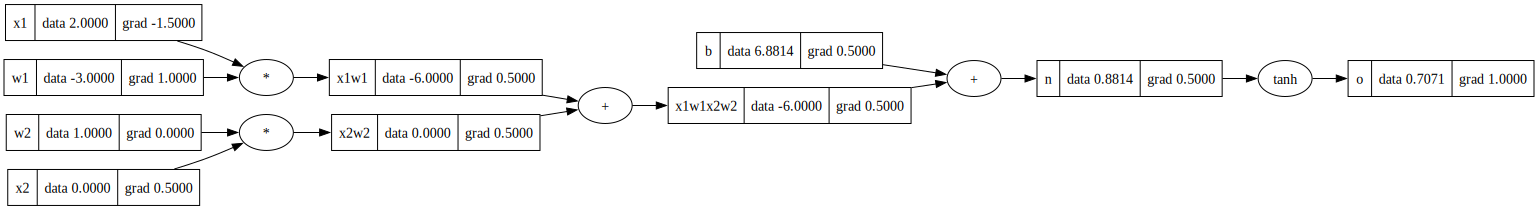

In [93]:

draw_dot(o)

In [92]:
o.backward()

In [68]:
o.grad = 1.0
o._backward()

In [72]:
n._backward()

In [74]:
b._backward()

In [76]:
x1w1x2w2._backward()

In [78]:
x1w1._backward()
x2w2._backward()

In [83]:
# using topological sort to avoid we implement the _backward() function manually

topo = []
visited = set() 
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)

build_topo(o)
topo


[Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [87]:
o.grad = 1.0

topo = []
visited = set() 
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)

build_topo(o)
topo

for node in reversed(topo):
    node._backward() 

In [2]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)  # to save the information about the value's children (who create him, maybe parents is a better name)
        self._op = _op  # the operation to create this value, like '+' or '*'
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, _children=(self, other), _op='+')
        def _backward():
            self.grad += 1* out.grad 
            other.grad += 1* out.grad 
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self + other 

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, _children=(self, other), _op='*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self*other
    
    def tanh(self):
        x = self.data
        tanh = (math.exp(2*x) - 1)/(math.exp(2*x) + 1 )
        out = Value(tanh, (self, ), 'tanh')
        def _backward():
            self.grad += (1 - tanh**2) * out.grad 
        out._backward = _backward
        return out 
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), 'only supporting the int/float powers for now' 
        x = self.data
        out = Value(math.pow(x, other), (self, ), f'**{other}')
        def _backward():
            self.grad = other* (x**(other - 1)) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

    def __truediv__(self, other):  # self / other
        return self * other ** -1

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # self - other
        return other + (-self)

    def __neg__(self):  # -self
        return self * -1

    def backward(self):
        self.grad = 1.0
        topo = []
        visited = set() 
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                # print (f'value: {v}')
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        for node in reversed(topo):
            node._backward() 

In [6]:
class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        # internal variables used for autograd graph construction
        self._backward = lambda: None
        self.label = label
        self._prev = set(_children)
        self._op = _op # the op that produced this node, for graphviz / debugging / etc

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward
        return out


    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                print (f'value: {v}')
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

In [3]:
from graphviz import Digraph

def trace(root):
    # build a set of nodes and edges of a computation grpah
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            # if isinstance(v, Value):
            if True:
                nodes.add(v)
                # print (f'value: {v}, label: {v.label}')
                for child in v._prev:
                    edges.add((child, v))
                    build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR= left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any node in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label="{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this node is created by some operations, create an op for it
            dot.node(name=uid+n._op, label=n._op)
            # connect this node to it
            dot.edge(uid+n._op, uid)
        
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2))+n2._op)
    
    return dot


In [14]:
# a simple example of a neuron
# input data
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weight 
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1x2w2'
n = x1w1x2w2 + b; n.label='n'
e = (2*n).exp(); e.label='e'
o = (e - 1)/(e + 1); o.label='o'

o.backward()

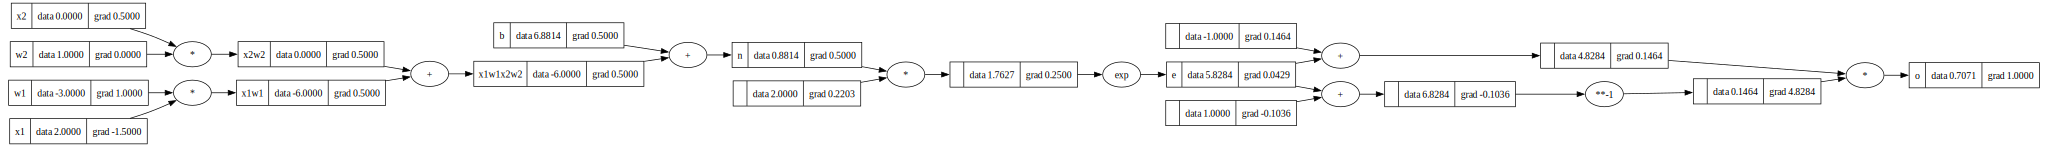

In [15]:
draw_dot(o)

In [171]:
# to varify our result with pytorch

In [172]:
import torch

In [174]:
x1 = torch.Tensor([2.0]).double()                                    ; x1.requires_grad=True
w1 = torch.Tensor([-3.0]).double()                                   ; w1.requires_grad=True
x2 = torch.Tensor([0.0]).double()                                    ; x2.requires_grad=True
w2 = torch.Tensor([1.0]).double()                                    ; w2.requires_grad=True
b = torch.Tensor([6.8813735870195432]).double()                      ; b.requreis_grad =True
n = x1*w1 + x2*w2 + b 
o = torch.tanh(n)

print(f'o is : {o.item()}')
o.backward()

print ('------')
print (f'grad of x1: {x1.grad.item()}')
print (f'grad of w1: {w1.grad.item()}')
print (f'grad of x2: {x2.grad.item()}')
print (f'grad of w2: {w2.grad.item()}')

o is : 0.7071066904050358
------
grad of x1: -1.5000003851533106
grad of w1: 1.0000002567688737
grad of x2: 0.5000001283844369
grad of w2: 0.0


In [ ]:
# a simple example of a neuron
# input data
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weight 
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1x2w2'
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label='o'

In [31]:
# let's build a MLP with Neuron shows above

class Neuron():
    def __init__(self, nin, num_neuron=0, num_layer=0):
        self.nin = nin
        self.num_neuron = num_neuron
        self.num_layer=num_layer
        self.ws =[Value(np.random.normal(size=1)[0], label=f'w{i}{num_neuron}{num_layer}') for i in range(nin)] 
        # label i,j,k. i:id of input, j: id of output, k: number of layers
        self.b = Value(np.random.normal(size=1)[0], label=f'b{num_neuron}{num_layer}')
    
    def __call__(self, xin: list):
        self.a = sum([xi*wi for xi, wi in zip(xin, self.ws)], self.b)
        self.a.label = f'act{self.num_neuron}{self.num_layer}'
        # print (f'self.a: {self.a}')
        self.o = self.a.tanh()
        self.o.label = f'out{self.num_neuron}{self.num_layer}'
        return self.o
    
    def parameters(self):
        params = self.ws + [self.b]
        return params

class NNLayer():
    def __init__(self, nin, nout, num_layer=0):
        self.nin = nin
        self.nout = nout
        self.neurons = [Neuron(nin, num_neuron=i, num_layer=num_layer) for i in range(nout)]
    def __call__(self, xin):
        outs = [neuron(xin) for neuron in self.neurons]
        return outs
    
    def parameters(self):
        params = [] 
        for neuron in self.neurons:
            params.extend(neuron.parameters())
        return params
    
class NNLayers():
    def __init__(self, nin, nouts: list):
        self.nin = nin
        self.nouts = nouts  # the number of neurons of each layer, a list
        num_neurons = [nin] + nouts
        self.layers = [NNLayer(num_neurons[i], num_neurons[i+1], num_layer=i+1) for i in range(len(num_neurons)-1)]
    
    def __call__(self, xin):
        for i in range(len(self.layers)):
            if i == 0:
                out = self.layers[0](xin)
            else:
                out = self.layers[i](out)
        return out
    
    def parameters(self):
        params = []
        for layer in self.layers:
            params.extend(layer.parameters())
        return params

In [5]:
nin = 3
nouts = [4, 4, 1]
xin = [Value(np.random.normal(size=1), label=f'x{i}') for i in range(nin)]
nnlayers = NNLayers(nin=nin, nouts=nouts)
out = nnlayers(xin)

In [6]:
[xin_.label for xin_ in xin]

['x0', 'x1', 'x2']

In [55]:
print(out)

[Value(data=0.9671264476375578)]


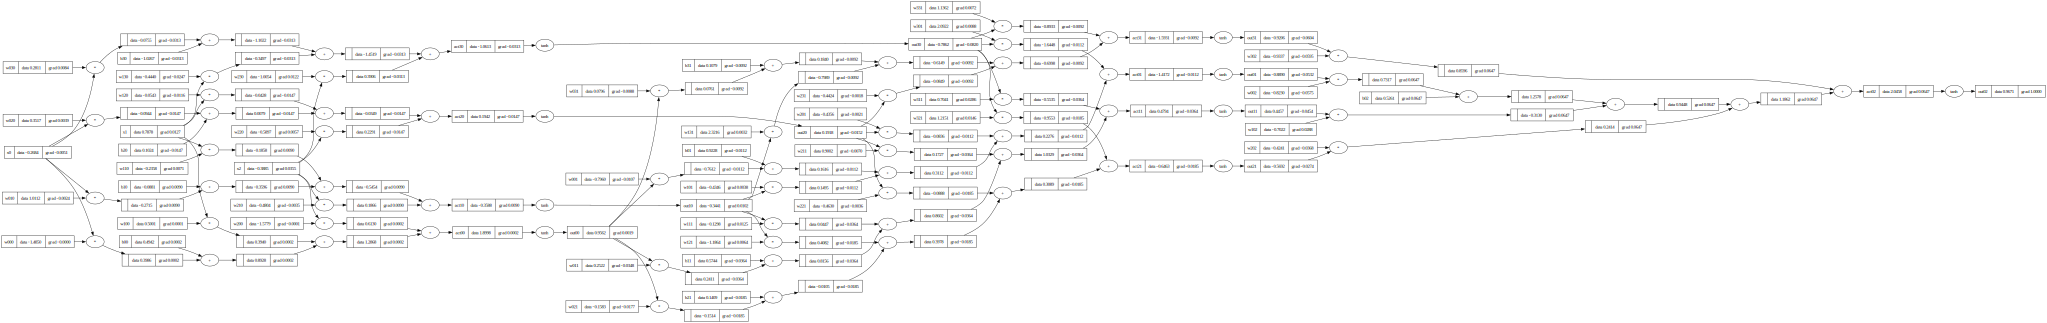

In [57]:
# neuron = Neuron(3)
# out = neuron()
out[0].backward()
draw_dot(out[0])

In [26]:
# let's try to build a simple neural network and train it with GD
nin = 3
nouts = [4, 4, 1]
x = [[2.0, 3.0, -1.0],
     [3.0, -1.0, 0.5],
     [0.5, 1.0, 1.0],
     [1.0, 1.0, -1.0]]
y = [1.0, -1.0, -1.0, 1.0]



In [50]:
nnlayers = NNLayers(nin=nin, nouts=nouts)
ypred = [nnlayers(xin)[0] for xin in  x]
ypred

[Value(data=-0.6082521331837178),
 Value(data=0.3496653800018418),
 Value(data=0.9888002277210443),
 Value(data=-0.152436645950446)]

In [34]:
avg_loss = sum([(y_ - ypred_)**2 for y_, ypred_ in zip(y, ypred)])/len(y)
avg_loss.backward()
avg_loss

Value(data=1.4098055466594788)

In [51]:
epochs = 200
lr = 0.05

for epoch in range(epochs):
    # forward:
    ypred = [nnlayers(xin)[0] for xin in  x]
    # compute loss
    avg_loss = sum([(y_ - ypred_)**2 for y_, ypred_ in zip(y, ypred)])/len(y)
    if epoch % 5 == 0:
        print (avg_loss)
    # zero the grad
    for p in nnlayers.parameters():
        p.grad = 0.0
    # compute gradient
    avg_loss.backward()
    # gradient descent
    for p in nnlayers.parameters():
        p.data -= lr*p.grad 

Value(data=2.422877032644571)
Value(data=1.63307594711006)
Value(data=1.1392913692032816)
Value(data=1.0512250483596834)
Value(data=1.0253562857153378)
Value(data=1.0131383609890807)
Value(data=1.0056362061389712)
Value(data=1.0000485697077695)
Value(data=0.9950877426649605)
Value(data=0.9897927664493231)
Value(data=0.9827693952022815)
Value(data=0.9700877338309201)
Value(data=0.9261242728477178)
Value(data=0.0511010721551386)
Value(data=0.02194171221114262)
Value(data=0.014932914131758167)
Value(data=0.011598890327236818)
Value(data=0.00960350670375947)
Value(data=0.008258073588352488)
Value(data=0.00728175344852352)
Value(data=0.006537023114084204)
Value(data=0.005948005842632347)
Value(data=0.005469152320314138)
Value(data=0.005071342212133799)
Value(data=0.0047350268668930285)
Value(data=0.004446561242243763)
Value(data=0.00419611248529056)
Value(data=0.003976404140627426)
Value(data=0.0037819291083724194)
Value(data=0.0036084382694483493)
Value(data=0.0034525978360334477)
Value(da

In [52]:

ypred = [nnlayers(xin)[0] for xin in  x]
ypred

[Value(data=0.9508749522573421),
 Value(data=-0.966415566729075),
 Value(data=-0.9450158284744724),
 Value(data=0.9426287954574507)]

In [41]:
nnlayers.layers[0].neurons[0].ws[1]

Value(data=-0.08258371781849641)

In [43]:
nnlayers.layers[0].neurons[0].ws[1].grad

-0.06978232682719045

In [53]:
len(nnlayers.parameters())

41